In [1]:
import numpy as np 
import pandas as pd 

import os
import torch
import torchvision
from PIL import Image
import os.path
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
traincsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_training.csv"
testcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_testing.csv"
valcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_validation.csv"
dataPath = "/content/drive/MyDrive/Thermal Imaging/DATASET/Filtered/"
bestModelPath = "/content/drive/MyDrive/Thermal Imaging/bestModel.pth"

In [5]:
traindf = pd.read_csv(traincsvPath)
testdf = pd.read_csv(testcsvPath)
valdf = pd.read_csv(valcsvPath)

# Create a list of train, test and val images, SBP and DBP

In [6]:
trainLabels = []
testLabels = []
valLabels = []

trainSBP = []
testSBP = []
valSBP = []

trainDBP = []
testDBP = []
valDBP = []

In [7]:
for index, row in traindf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  trainLabels.append(dataPath + row['Image'])
  trainSBP.append(row['SBP'])
  trainDBP.append(row['DBP'])

for index, row in testdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  testLabels.append(dataPath + row['Image'])
  testSBP.append(row['SBP'])
  testDBP.append(row['DBP'])

for index, row in valdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  valLabels.append(dataPath + row['Image'])
  valSBP.append(row['SBP'])
  valDBP.append(row['DBP'])

# Apply Image transformation, extract features and create dataloader class

## Image Transformation and feature extraction model

In [8]:
# Image Transformations as expected by resnet101 as input
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(

  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [10]:
layers = list(efficientnet.children())[:-1]
effModel = torch.nn.Sequential(*layers)
effModel.to('cpu')
effModel.eval()
effModel

Sequential(
  (0): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
        (proj): 

In [11]:
trainImgs, testImgs, valImgs = [], [], []

# Transform and load image vectors in trainImgs, testImgs, valImgs
for img in trainLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = effModel(image).detach().numpy()
  trainImgs.append(feature)

for img in testLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = effModel(image).detach().numpy()
  testImgs.append(feature)

for img in valLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = effModel(image).detach().numpy()
  valImgs.append(feature)

In [12]:
# Dataset class 
class thermalDataset(Dataset):
  def __init__(self, features, sbp, dbp):
      super().__init__()
      self.features = features
      self.sbp = sbp 
      self.dbp = dbp

  def __len__(self):
    return len(self.features)

  def __getitem__(self, indx):
    self.sbp[indx] = np.float32(self.sbp[indx] / 180.00)
    self.dbp[indx] = np.float32(self.dbp[indx] / 180.00)
    return {'feature': self.features[indx], 'sbp': self.sbp[indx], 'dbp': self.dbp[indx]}

In [13]:
train_dataset = thermalDataset(trainImgs, trainSBP, trainDBP)
test_dataset = thermalDataset(testImgs, testSBP, testDBP)
val_dataset = thermalDataset(valImgs, testSBP, testDBP)

train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True, num_workers = 1)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = True, num_workers = 1)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = 16, shuffle = True, num_workers = 1)

# Model Implementation (Alexnet Feature Layers + Dense Layers)

In [14]:
# Removed classification layers, used pretrained alexnet for feature extraction, added own fcc layers.
class modifiedpreTrainedEffNet(torch.nn.Module):
  def __init__(self):
    super(modifiedpreTrainedEffNet, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(62720, 8192, bias=True)

    self.fcsbp1 = torch.nn.Linear(8192, 4096, bias=True) #FOR SBP
    self.fcsbp2 = torch.nn.Linear(4096, 1024, bias=True)
    self.fcsbpout = torch.nn.Linear(1024, 1, bias=True) # SBP output

    self.fcdbp1 = torch.nn.Linear(8192, 4096, bias=True) #For DBP
    self.fcdbp2 = torch.nn.Linear(4096, 1024, bias=True) 
    self.fcdbpout = torch.nn.Linear(1024, 1, bias=True) #DBP output

  def forward(self, features):
    features = self.flatten(features)
    features = F.relu(self.fc1(features)) #First FCC Layer

    sbp = F.relu(self.fcsbp1(features))     #SBP output
    sbp = F.relu(self.fcsbp2(sbp))
    sbp = F.relu(self.fcsbpout(sbp))

    dbp = F.relu(self.fcdbp1(features))     #DBP output
    dbp = F.relu(self.fcdbp2(dbp))
    dbp = F.relu(self.fcdbpout(dbp))

    return {'sbp': sbp, 'dbp': dbp}

    

In [15]:
def plotLosses(trainLoss, validationLoss, trainSBP, trainDBP, valSBP, valDBP):
  plt.figure(figsize=(10,5))
  plt.plot(trainLoss)
  plt.plot(validationLoss)
  plt.plot(trainSBP)
  plt.plot(trainDBP)
  plt.plot(valSBP)
  plt.plot(valDBP)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Epoch vs Loss")
  plt.legend(['Training Loss', 'Validation Loss', 'Train SBP Loss', 'Train DBP Loss', 'Val SBP loss', 'Val DBP Loss'])
  plt.grid()
  plt.show()

# Training the model

Epoch:  0   TrainLoss:  1.5346947759389877 TrainSBPLoss:  1.0500066671520472 TrainDBPLoss:  0.4846881269477308
Epoch:  0   ValLoss:  1.5346947759389877 ValSBPLoss:  1.0500066671520472 ValDBPLoss:  0.4846881269477308
Epoch:  1   TrainLoss:  0.5565980328246951 TrainSBPLoss:  0.3834409862756729 TrainDBPLoss:  0.17315704945940524
Epoch:  1   ValLoss:  0.5565980328246951 ValSBPLoss:  0.3834409862756729 ValDBPLoss:  0.17315704945940524
Epoch:  2   TrainLoss:  0.28264220943674445 TrainSBPLoss:  0.19697893253760412 TrainDBPLoss:  0.08566327136941254
Epoch:  2   ValLoss:  0.28264220943674445 ValSBPLoss:  0.19697893253760412 ValDBPLoss:  0.08566327136941254
Epoch:  3   TrainLoss:  0.09003770351409912 TrainSBPLoss:  0.07059242081595585 TrainDBPLoss:  0.01944528368767351
Epoch:  3   ValLoss:  0.09003770351409912 ValSBPLoss:  0.07059242081595585 ValDBPLoss:  0.01944528368767351
Epoch:  4   TrainLoss:  0.05260759824886918 TrainSBPLoss:  0.030963094672188163 TrainDBPLoss:  0.021644503518473357
Epoch:

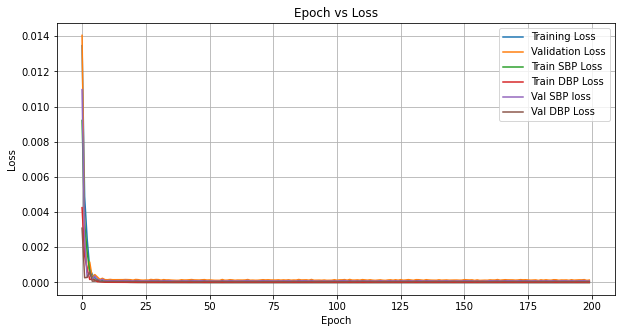

In [16]:
num_epochs = 200
steps_per_epoch = len(trainImgs)
model = modifiedpreTrainedEffNet()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()

trainLoss = []
validationLoss = []
trainSBPLoss = []
trainDBPLoss = []
valSBPLoss = []
valDBPLoss = []

valLossMIN = 10000

for epoch in range(num_epochs):
  trainloss = 0.0
  valLoss = 0.0
  trainsbpLoss = 0.0
  traindbpLoss = 0.0
  valsbpLoss = 0.0
  valdbpLoss = 0.0
  model.train()

  for batch_idx, sample in enumerate(train_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    optimizer.zero_grad()
    output = model(feature)
    sbp = sbp.unsqueeze(1)
    dbp = dbp.unsqueeze(1)
    sbpLoss = criterion(output['sbp'], sbp)
    dbpLoss = criterion(output['dbp'], dbp)
    loss = sbpLoss + dbpLoss
    loss.backward()
    optimizer.step()    

    trainloss += loss.item()
    trainsbpLoss += sbpLoss.item()
    traindbpLoss += dbpLoss.item()

  trainLoss.append(trainloss/len(trainImgs))
  trainSBPLoss.append(trainsbpLoss/len(trainImgs))
  trainDBPLoss.append(traindbpLoss/len(trainImgs))

  print("Epoch: ", epoch, "  TrainLoss: ", trainloss, "TrainSBPLoss: ", trainsbpLoss, "TrainDBPLoss: ", traindbpLoss)

  with torch.no_grad():
    model.eval()
    for batch_idx, sample in enumerate(val_data_loader):
      feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
      output = model(feature)
      sbp = sbp.unsqueeze(1)
      dbp = dbp.unsqueeze(1)
      sbpLoss = criterion(output['sbp'], sbp)
      dbpLoss = criterion(output['dbp'], dbp)
      loss = sbpLoss + dbpLoss
      
      valLoss += loss.item()
      valsbpLoss += sbpLoss.item()
      valdbpLoss += dbpLoss.item()

  validationLoss.append(valLoss/len(valImgs))
  valSBPLoss.append(valsbpLoss/len(valImgs))
  valDBPLoss.append(valdbpLoss/len(valImgs))  

  print("Epoch: ", epoch, "  ValLoss: ", trainloss, "ValSBPLoss: ", trainsbpLoss, "ValDBPLoss: ", traindbpLoss)

plotLosses(trainLoss, validationLoss, trainSBPLoss, trainDBPLoss, valSBPLoss, valDBPLoss)

# Testing the model

In [17]:
sbps = []
dbps = []
outputsbps = []
outputdbps = []

with torch.no_grad():
  model.eval()
  for batch_idx, sample in enumerate(test_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    output = model(feature)
    sbps.append(sbp.unsqueeze(1))
    dbps.append(dbp.unsqueeze(1))
    outputsbps.append(output['sbp'])
    outputdbps.append(output['dbp'])

In [18]:
sbp = sbps[0]
dbp = dbps[0]
outputsbp = outputsbps[0]
outputdbp = outputdbps[0]

for i in range(1,len(sbps)):
  sbp = torch.cat((sbp, sbps[i]))
  dbp = torch.cat((dbp, dbps[i]))
  outputsbp = torch.cat((outputsbp, outputsbps[i]))
  outputdbp = torch.cat((outputdbp, outputdbps[i]))

In [19]:
# Calculates Mean Absolute % error
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output) / target))

In [20]:
print("MAPE for SBP: ", MAPELoss(outputsbp, sbp), "MAPE for DBP: ", MAPELoss(outputdbp, dbp))

MAPE for SBP:  tensor(0.0357, device='cuda:0') MAPE for DBP:  tensor(0.0475, device='cuda:0')


# Visualizations

## Ground value vs Predicted Value

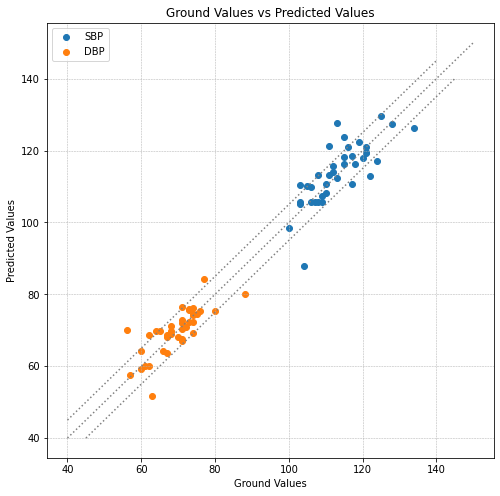

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(sbp.to('cpu')*180.0, outputsbp.to('cpu')*180.0)
plt.scatter(dbp.to('cpu')*180.0, outputdbp.to('cpu')*180.0)
plt.xlabel("Ground Values")
plt.ylabel("Predicted Values")
plt.title("Ground Values vs Predicted Values")
plt.legend(['SBP', 'DBP'])
plt.plot([40, 150], [40, 150], ls='dotted', color='#808080')

# +-  10 mm Hg range
# plt.plot([40, 140], [50, 150], ls='dotted', color='#808080')
# plt.plot([50, 150], [40, 140], ls='dotted', color='#808080')

# +- 5 mm Hg range
plt.plot([40, 140], [45, 145], ls='dotted', color='#808080')
plt.plot([45, 145], [40, 140], ls='dotted', color='#808080')
plt.grid(linestyle = '--', linewidth = 0.5)
plt.show()

## Absolute Error (DBP) vs Absolute Error(SBP)

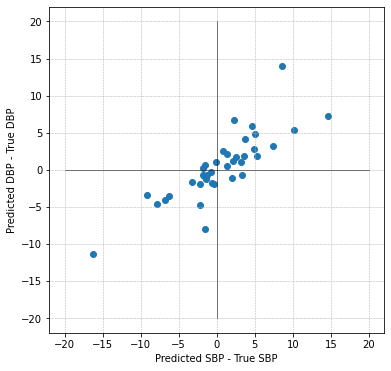

In [22]:
sbpError = outputsbp - sbp
dbpError = outputdbp - dbp

plt.figure(figsize=(6,6))
plt.scatter(sbpError.to('cpu')*180.0, dbpError.to('cpu')*180.0)
plt.xlabel("Predicted SBP - True SBP")
plt.ylabel("Predicted DBP - True DBP")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot([0, 0], [-20, 20], linewidth = 0.5, color="#000000")
plt.plot([-20, 20], [0, 0], linewidth = 0.5, color="#000000")
plt.xticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
plt.yticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
plt.show()